In [30]:
import nltk
from nltk import word_tokenize, pos_tag, RegexpParser
from nltk.chunk import conlltags2tree, tree2conlltags, ne_chunk
import spacy
import svgling
from transformers import AutoModelForTokenClassification, AutoTokenizer, get_scheduler, pipeline

In [20]:
nltk.download("maxent_ne_chunker_tab")

[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/vsaravind/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.


True

In [3]:
nlp = spacy.load("en_core_web_sm")
ner_categories = ["PERSON", "LOC"]

In [4]:
text = "Show all the photos of Bob and Aravind"
doc = nlp(text.lower())

In [5]:
doc.ents

()

In [14]:
sent = pos_tag(word_tokenize(text), lang='eng')
print(sent)

[('Show', 'NNP'), ('all', 'PDT'), ('the', 'DT'), ('photos', 'NN'), ('of', 'IN'), ('Bob', 'NNP'), ('and', 'CC'), ('Aravind', 'NNP')]


After Chunking (S
  (mychunk Show/NNP)
  all/PDT
  the/DT
  (mychunk photos/NN)
  of/IN
  (mychunk Bob/NNP)
  and/CC
  (mychunk Aravind/NNP))


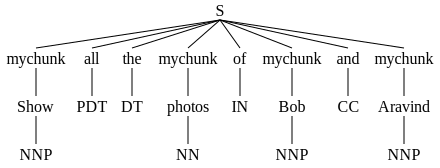

In [15]:
patterns = """mychunk:{<NN.*>+}"""
chunker = RegexpParser(patterns)
output = chunker.parse(sent)
print("After Chunking", output)
svgling.draw_tree(output)

In [16]:
iob_tagged = tree2conlltags(output)
print(iob_tagged)

[('Show', 'NNP', 'B-mychunk'), ('all', 'PDT', 'O'), ('the', 'DT', 'O'), ('photos', 'NN', 'B-mychunk'), ('of', 'IN', 'O'), ('Bob', 'NNP', 'B-mychunk'), ('and', 'CC', 'O'), ('Aravind', 'NNP', 'B-mychunk')]


In [29]:
def extract_ne(trees, labels):

    ne_list = []
    for tree in ne_res:
        if hasattr(tree, "label"):
            if tree.label() in labels:
                ne_list.append(tree)
    return ne_list


ne_res = ne_chunk(pos_tag(word_tokenize(text)))
labels = ["PERSON"]

print(extract_ne(ne_res, labels))

[Tree('PERSON', [('Bob', 'NNP')]), Tree('PERSON', [('Aravind', 'NNP')])]


In [32]:
model_checkpoint_default = "dslim/bert-base-NER"
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint_default)
model_checkpoint = "dslim/bert-base-NER"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

print("Entities from the pretrained model")
model.config.id2label

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Entities from the pretrained model


/Users/vsaravind/dev/ChatterChum/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


{0: 'O',
 1: 'B-MISC',
 2: 'I-MISC',
 3: 'B-PER',
 4: 'I-PER',
 5: 'B-ORG',
 6: 'I-ORG',
 7: 'B-LOC',
 8: 'I-LOC'}

In [42]:
import torch
import numpy as np

test_sentence = """Show all the photos of bob and jack"""
# Vice President Kamala Harris Tweet 5th July 2022

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence])
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to("cpu").numpy(), axis=2)

tokens = tokenizer.convert_ids_to_tokens(input_ids.to("cpu").numpy()[0])
new_tokens, new_labels = [], []

for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(label_idx)
        new_tokens.append(token)

In [43]:
dict1 = {
    "B-PER": "B-PERSON",
    "B-LOC": "B-LOCATION",
    "O": "Other",
    "I-LOC": "I-LOCATION",
}
tags = []
_words = []
for token, label in zip(new_tokens, new_labels):
    tags.append(dict1[model.config.id2label[label]])
    _words.append(token)

In [52]:
from nltk.corpus import words
from collections import Counter

In [55]:
def extract_uncommon_words(text):
    """Extracts uncommon English words from a given text."""

    nltk.download("words")
    english_words = set(words.words())

    # Tokenize the text and convert to lowercase
    _words = nltk.word_tokenize(text.lower())

    # Filter out non-alphabetic words
    _words = [word for word in _words if word.isalpha()]

    # Calculate word frequencies
    word_counts = Counter(_words)

    # Extract uncommon words
    uncommon_words = [
        word for word, count in word_counts.items() if word not in english_words or count < 2
    ]

    return uncommon_words

text = "Show all the photos of Bob and Jack"
uncommon_words = extract_uncommon_words(text)
print(uncommon_words)

[nltk_data] Downloading package words to /Users/vsaravind/nltk_data...
[nltk_data]   Package words is already up-to-date!


UnboundLocalError: local variable 'words' referenced before assignment

In [ ]:
import re

lst = []
total_words = []
temp = 0
for key, i in enumerate(words[1:-1]):
    # print(i)
    if i not in total_words:
        re_string = r"\b({})\b".format(i)
        start = re.search(re_string, test_sentence).start()
        end = re.search(re_string, test_sentence).end()
        dict1 = {}
        dict1["start"] = start + temp
        dict1["end"] = end
        dict1["label"] = tags[1:-1][key]
        dict1["Word"] = i
        total_words.append(i)

        lst.append(dict1)

    else:
        start = start + len(words[1:-1][key - 1])
        end = end + len(i) + 1

        dict1 = {}
        dict1["start"] = start
        dict1["end"] = end
        dict1["label"] = tags[1:-1][key] + "2"
        dict1["Word"] = i
        total_words.append(i)

        lst.append(dict1)
ex = [{"text": test_sentence, "ents": lst, "title": None}]
cols = {
    "B-PERSON": "#dad1f6",
    "I-LOCATION": "#adcfad",
    "OTHER2": "#fbbf9a",
    "B-LOCATION": "#bdf2fa",
    "I-GENE_OR_GENOME": "#eea69e",
    "OTHER": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
}
options = {
    "colors": cols,
}

html = displacy.render(ex, style="ent", options=options, manual=True)